# Spiral dataset

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

from progressbar import ProgressBar

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style

In [2]:
sns.set(style="white", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Just for the sake of reproducibility

In [3]:
np.random.seed(21)

# Generate artificial data
Let's generate artificial data using numpy. Here we want to have 3 classses placed in the form of spiral each.

In [4]:
n_samples = 100  # number of points per class
n_dims    = 2    # number of dimensions
n_classes = 3    # number of classes

We want the data to form spirals

In [5]:
def get_data(n_samples=100, n_classes=3, random_state=None):
    """
    Generate 2D spiral data
    
    Args:
        n_samples(int): number of samples per class
        n_classes(int): number of classes
        random_state(int): random state to fix
        
    Return:
        X(ndarray): array of points
        y(ndarray): labels
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    X = np.zeros((n_samples * n_classes, 2))
    y = np.zeros(n_samples * n_classes, dtype='uint8')
    
    for j in range(n_classes):
        ix = range(n_samples * j, n_samples * (j + 1))
        r = np.linspace(0.0, 1, n_samples) # radius
        t = np.linspace(j * 4, (j + 1) * 4, n_samples) + np.random.randn(n_samples) * 0.2 # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    
    return X, y

Let's generate both train and validation samples

In [6]:
X_train, y_train = get_data(random_state=21)
X_valid, y_valid = get_data(n_samples=50, random_state=12)

Visualize train data

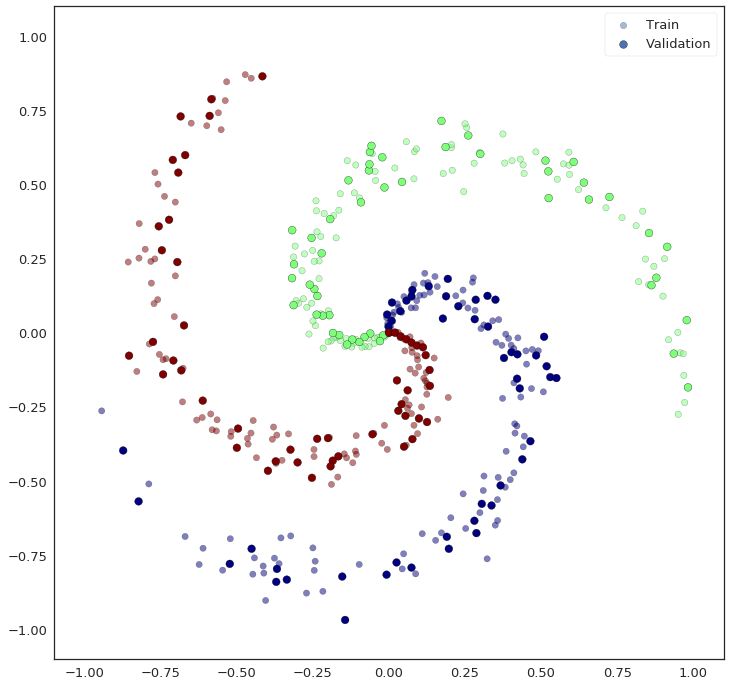

In [7]:
plt.figure(figsize=(12, 12))
plt.scatter(X_train[:, 0], X_train[:, 1], s=40, 
            c=y_train, cmap="jet", edgecolors="k", alpha=0.5, 
            label="Train")
plt.scatter(X_valid[:, 0], X_valid[:, 1], s=60, 
            c=y_valid, cmap="jet", edgecolors="k", 
            label="Validation")
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.legend();

# Logistic regression baseline

Let's take Sklearn implementation of logistic ragression and build a baseline model

In [8]:
model_lr = LogisticRegression(C = 1e8, 
                              max_iter=200, 
                              solver="sag", 
                              multi_class="multinomial")

Fitting

In [9]:
model_lr.fit(X_train, y_train)

LogisticRegression(C=100000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

In [10]:
print("Train accuracy: {:.1f}%".format(model_lr.score(X_train, y_train) * 100))
print("Valid accuracy: {:.1f}%".format(model_lr.score(X_valid, y_valid) * 100))

Train accuracy: 52.3%
Valid accuracy: 53.3%


Plot the resulting classifier

In [11]:
def plot_model(model, X, y, val_data=None):
    # get limits
    x_min, x_max = X[:, 0].min() * 1.1, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 1.1, X[:, 1].max() * 1.1
    # generate mesh grid
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # get model predictions
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # plot
    plt.figure(figsize=(12, 12))
    plt.contourf(xx, yy, Z, cmap="jet", alpha=0.1)
    if val_data is not None:
        X_valid, y_valid = val_data
        plt.scatter(X[:, 0], X[:, 1], s=40, 
                    c=y, cmap="jet", edgecolors="k", alpha=0.5, 
                    label="Train")
        plt.scatter(X_valid[:, 0], X_valid[:, 1], s=60, 
                    c=y_valid, cmap="jet", edgecolors="k", alpha=1.0, 
                    label="Validation")
    else:
        plt.scatter(X[:, 0], X[:, 1], s=40, 
                    c=y, cmap="jet", edgecolors="k", alpha=1.0, 
                    label="Train")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()

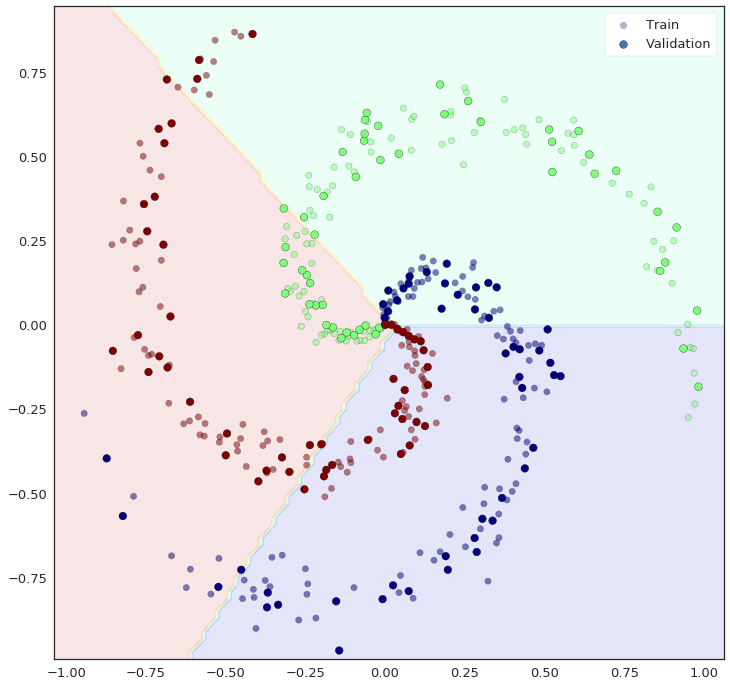

In [12]:
plot_model(model_lr, X_train, y_train, (X_valid, y_valid))

Linear classifier does very poor here!

# MLP

Build a multilayer 2-100-3 NN Classifier

Let's initialize parameters randomly

In [13]:
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(n_dims, h)
b1 = np.zeros((1, h))
W2 = 0.01 * np.random.randn(h, n_classes)
b2 = np.zeros((1, n_classes))

And also hyperparameters: step size

In [14]:
alpha = 1e-0

Backpropagation algorithm

In [15]:
# gradient descent loop
num_examples = X_train.shape[0]
for i in range(10000):

    # evaluate class scores, [n_samples x n_classes]
    hidden_layer = np.maximum(0, np.dot(X_train, W1) + b1) # ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss
    corect_logprobs = -np.log(probs[range(num_examples), y_train])
    data_loss = np.sum(corect_logprobs) / num_examples
    loss = data_loss
    if (i + 1) % 1000 == 0:
        print("iteration %d: loss %f" % (i + 1, loss))

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples), y_train] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # perform a parameter update
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2

iteration 1000: loss 0.118521
iteration 2000: loss 0.072797
iteration 3000: loss 0.044433
iteration 4000: loss 0.035767
iteration 5000: loss 0.031093
iteration 6000: loss 0.028008
iteration 7000: loss 0.025809
iteration 8000: loss 0.024079
iteration 9000: loss 0.022709
iteration 10000: loss 0.021607


Evaluation

In [16]:
class dummy_predictor():
    def __init__(self):
        pass
    def predict(self, X):
        hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
        scores = np.dot(hidden_layer, W2) + b2
        predicted_class = np.argmax(scores, axis=1)
        return predicted_class

In [17]:
preds_train = dummy_predictor().predict(X_train)
preds_valid = dummy_predictor().predict(X_valid)
print("Train accuracy: {:.1f}%".format(np.mean(preds_train == y_train) * 100))
print("Valid accuracy: {:.1f}%".format(np.mean(preds_valid == y_valid) * 100))

Train accuracy: 99.3%
Valid accuracy: 98.7%


Plot the decision surface

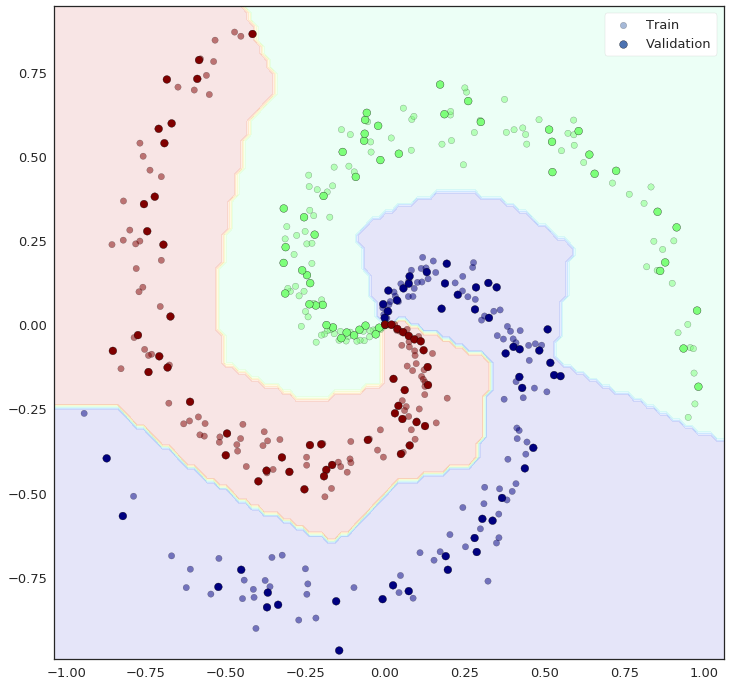

In [18]:
plot_model(dummy_predictor(), X_train, y_train, (X_valid, y_valid))

# Class structure

Let's implement BackProp algorithm with the same class structure as we did in previous notebooks.

In [19]:
class MLPHomegrownSoftmax(object):
    
    def __init__(self, layer_config=[], random_state=21, verbose=True, _allow_multiple_layers=False):
        
        self.verbose = verbose
        
        self._random_state = random_state
        
        self._layer_config = layer_config
        self._n_config = len(layer_config)

        # input dimensionality
        self._input_dim = layer_config[0]
        # number of classes
        self._n_classes = layer_config[-1]
        
        # Number of hidden layers
        self._hidden_config = layer_config[1:-1]
        self.n_hidden = len(self._hidden_config)
        if not _allow_multiple_layers:
            assert self.n_hidden == 1, "This implementation allows only for one hidden layer"
        
        # Initialize hidden layers
        self._init_hidden_layers()

        # Track History
        self.history = {"loss": [], 
                        "acc": [], 
                        "val_loss":[], 
                        "val_acc": []}

    def _init_hidden_layers(self):
        if self._random_state:
            np.random.seed(self._random_state)

        lc = self._layer_config
        
        self._Ws = [] 
        self._bs = []
        
        for i in range(self._n_config - 1):
            # weight matrix
            w_i = 0.01 * np.random.randn(lc[i], lc[i + 1])
            self._Ws.append(w_i)
            # bias vector
            b_i = np.zeros((1, lc[i + 1]))
            self._bs.append(b_i)

    def _grad(self, X, y):
        """
        Calculates the gradient.
        Only works for one hidden layer for now.

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        
        hidden_layer = self.hidden_layer    
        W2 = self._Ws[1]
        
        # number of training examples
        num_examples = X.shape[0]
        
        # get probs from last scoring step
        probs = self.probs
    
        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples), y] -= 1
        dscores /= num_examples

        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # finally into W,b
        dW1 = np.dot(X.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        
        # Store the updates # FIXME for multiple hidden
        self._dWs = [dW1, dW2]
        self._dbs = [db1, db2]

    def _update_grad(self):
        """
        Update the weights and the biases
        """
        for i in range(self._n_config - 1):
            self._Ws[i] -= self.alpha * self._dWs[i]
            self._bs[i] -= self.alpha * self._dbs[i]
        
    def _bp(self, X, y, max_iter, X_valid, y_valid):
        """
        Runs Full GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates

        Return:
            None
        """

        # gradient descent loop
        for i in range(max_iter):
            metrics = self.score(X, y, store=True)
            self.history["loss"].append(metrics["loss"])
            self.history["acc"].append(metrics["acc"])
            
            if X_valid is not None:
                # calculate for validation purposes but don't store the vals
                metrics_val = self.score(X_valid, y_valid, store=False)
                self.history["val_loss"].append(metrics_val["loss"])
                self.history["val_acc"].append(metrics_val["acc"])

            # calculate gradient
            self._grad(X, y)
            
            # do parameter update step
            self._update_grad()
            
            if self.verbose and (i + 1) % 1000 == 0:
                print("iteration %d: loss %f" % (i + 1, self.loss))

    def _accuracy(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)

    def fit(self, X, y, max_iter=10000, alpha=0.05, val_data=None):
        """
        Public API to fit 
        
        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floor):    step size in direction of gradient
            
        Return:
            None
        """
        self.alpha = alpha   

        if val_data is not None:
            X_valid, y_valid = val_data
        else:
            X_valid = None
            y_valid = None

        # do gradient descent with back prop
        self._bp(X, y, max_iter, X_valid, y_valid)
        
    def score(self, X, y, store=True):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            store(bool):     persist the results in the object
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy 
                             and for objective function
        """        
        # number of training samples
        num_examples = X.shape[0]
        
        # get probabilities
        probs = self._predict_raw(X, store=store)
        
        # compute the loss: average cross-entropy loss
        corect_logprobs = -np.log(probs[range(num_examples), y])
        
        # total mean logloss
        data_loss = np.sum(corect_logprobs) / num_examples

        # predictions
        pred = np.argmax(probs, axis=1)
        # accuracy
        acc = self._accuracy(y, pred)
        
        # final metrics
        metrics = {"acc": acc, "loss": data_loss}
        
        # persist the results in the object
        if store:
            self.probs = probs
            self.loss = data_loss
        
        return metrics
        
    def _predict_raw(self, X, store=True):
        """
        Computes scores (probas) for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """

        # evaluate class scores
        hidden_layer = np.maximum(0, np.dot(X, self._Ws[0]) + self._bs[0]) # ReLU activation
        
        # keep for later calulation 
        if store:
            self.hidden_layer = hidden_layer

        # raw scores before softmax
        scores = np.dot(hidden_layer, self._Ws[1]) + self._bs[1]
        
        # trasnform scores to probabilities
        exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probs
    
    def predict(self, X):
        """
        Predicts class for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            pred(ndarray):   class for each object
        """
        
        # get probabilities for each class
        scores = self._predict_raw(X)
        # choose class with maximum probability
        pred = np.argmax(scores, axis=1)
        return pred

Now let's check our implementation.

First of all, create a model:

In [20]:
model_mlp = MLPHomegrownSoftmax(layer_config=[2, 100, 3], random_state=21)

And then fit:

In [21]:
model_mlp.fit(X_train, y_train, max_iter=10000, alpha=1e-0, val_data=(X_valid, y_valid))

iteration 1000: loss 0.128854
iteration 2000: loss 0.057038
iteration 3000: loss 0.040725
iteration 4000: loss 0.033125
iteration 5000: loss 0.028642
iteration 6000: loss 0.025636
iteration 7000: loss 0.023542
iteration 8000: loss 0.022031
iteration 9000: loss 0.020875
iteration 10000: loss 0.019945


Let's see how the training procedure was doing

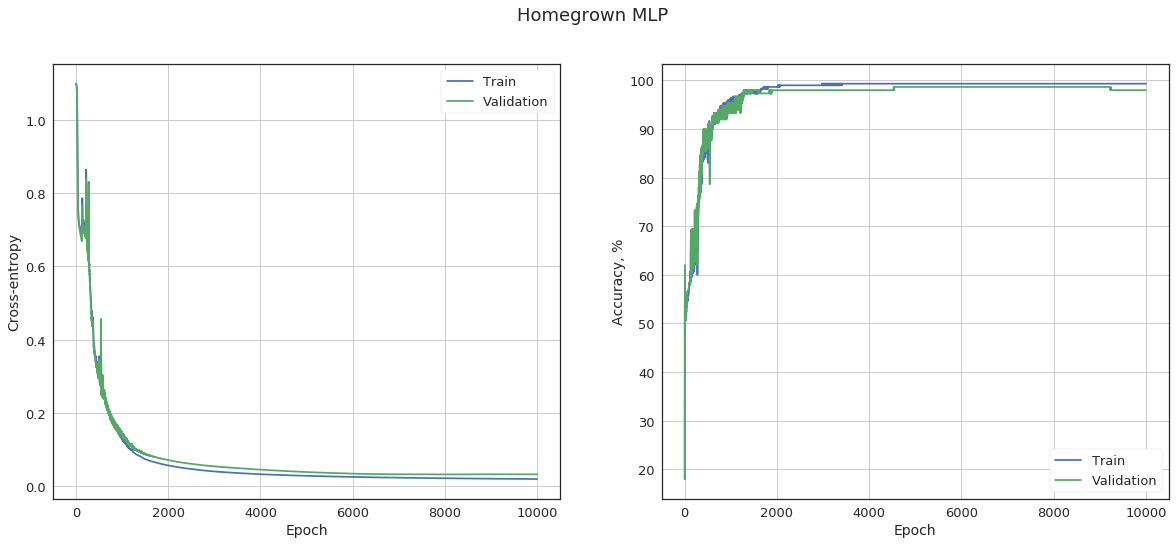

In [22]:
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown MLP", fontsize=18)

plt.subplot(121)
plt.plot(model_mlp.history["loss"], label="Train")
plt.plot(model_mlp.history["val_loss"], label="Validation")
plt.grid("on")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Cross-entropy", fontsize=14)

plt.subplot(122)
plt.plot(np.array(model_mlp.history["acc"]) * 100, label="Train")
plt.plot(np.array(model_mlp.history["val_acc"]) * 100, label="Validation")
plt.grid("on")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy, %", fontsize=14);

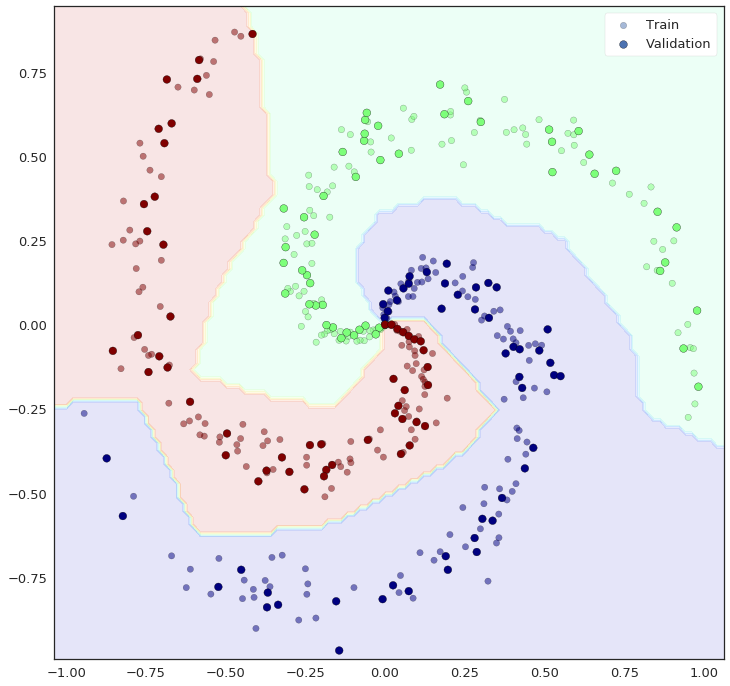

In [23]:
plot_model(model_mlp, X_train, y_train, (X_valid, y_valid))

The same picture as we've seen with naive python implementation. That's great!

In [24]:
print("Train accuracy: {:.1f}%".format(model_mlp.score(X_train, y_train)["acc"] * 100))
print("Valid accuracy: {:.1f}%".format(model_mlp.score(X_valid, y_valid)["acc"] * 100))

Train accuracy: 99.3%
Valid accuracy: 98.0%


# Multilayer NN

For now there is only one hidden layes in MLP. Let's implement the BackProp algorithm in the way that it can work with arbitary number of layers. Test on the three hidden layer network with configuration 2-40-40-40-3 and compare its performance to the initial one hidden layer network.

Here we need to override only a few methods from `MLPHomegrown` class.

In [25]:
class MLPHomegrownSoftmaxMulti(MLPHomegrownSoftmax):
    
    def __init__(self, layer_config=[], random_state=21, verbose=True, _allow_multiple_layers=True):
        """
        Constructor for the homegrown MLP
        """
        # call the constructor of the parent class
        super(MLPHomegrownSoftmaxMulti, self).__init__(layer_config=layer_config, 
                                                       random_state=random_state, 
                                                       verbose=verbose, 
                                                       _allow_multiple_layers=_allow_multiple_layers)

    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        # number of training examples
        num_examples = X.shape[0]
        
        # get probs from last scoring step
        probs = self.probs

        # compute the gradient on scores
        # Calculate the error; subtract 1 since we only have on class
        # that is 'on' at a time (even though we have multiple classes)
        dscores = probs
        dscores[range(num_examples), y] -= 1
        # normalize by dividing by number of examples
        dscores /= num_examples
        
        delta = dscores
        dWs = [np.zeros_like(W) for W in self._Ws]
        dbs = [np.zeros_like(b) for b in self._bs]
        Ws = self._Ws
        Os = self._Os
        
        for neg_id in range(self.n_hidden + 1):
            j = -1 - neg_id
            Wj = Ws[j] # output
            hj = Os[j] # hidden
            # backpropate the gradient to the parameters
            # first backprop into parameters W2 and b2
            dW = np.dot(hj.T, delta) # gradient
            db = np.sum(delta, axis=0, keepdims=True)
            # next backprop into hidden layer
            dhidden = np.dot(delta, Wj.T)
            # backprop the ReLU non-linearity
            dhidden[hj <= 0] = 0
            
            # update delta
            delta = dhidden
            
            # store updates
            dWs[j] = dW
            dbs[j] = db

        # Store the updates 
        self._dWs = dWs
        self._dbs = dbs

    def _predict_raw(self, X, store=True):
        """
        Forward prop
        
        Computes scores for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """
        # output for the input layer is its actual input value
        Os = [X]

        # Propagate the inputs forward 
        for j in range(self.n_hidden):
            # evaluate class scores
            hidden_layer = np.maximum(0, np.dot(Os[j], self._Ws[j]) + self._bs[j]) # ReLU activation
            Os.append(hidden_layer)

        # Keep for later calulation 
        if store:
            self._Os = Os

        scores = np.dot(Os[-1], self._Ws[-1]) + self._bs[-1]
        
        # trasnform scores to probabilities
        exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return probs

Now let's check our implementation.

First of all, create a model:

In [26]:
model_mlp_multi = MLPHomegrownSoftmaxMulti(layer_config=[2, 40, 40, 40, 3], random_state=21)

And then fit:

In [27]:
model_mlp_multi.fit(X_train, y_train, max_iter=10000, alpha=5e-1, val_data=(X_valid, y_valid))

iteration 1000: loss 1.098612
iteration 2000: loss 1.098611
iteration 3000: loss 1.098609
iteration 4000: loss 1.098581
iteration 5000: loss 0.511658
iteration 6000: loss 0.036598
iteration 7000: loss 0.042058
iteration 8000: loss 0.023923
iteration 9000: loss 0.017199
iteration 10000: loss 0.016736


Let's see how the training procedure was doing

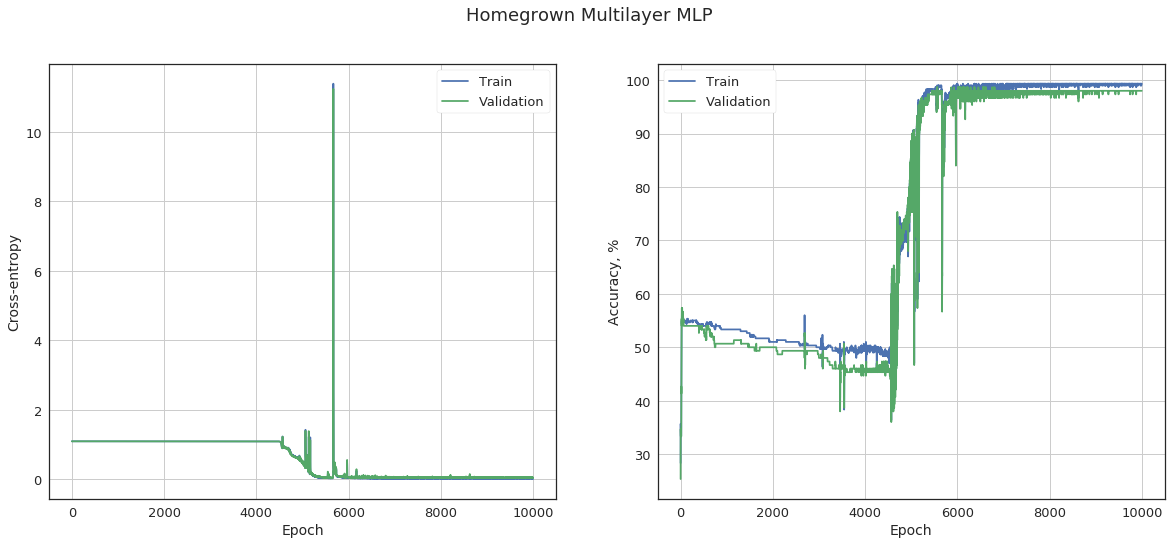

In [28]:
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown Multilayer MLP", fontsize=18)

plt.subplot(121)
plt.plot(model_mlp_multi.history["loss"], label="Train")
plt.plot(model_mlp_multi.history["val_loss"], label="Validation")
plt.grid("on")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Cross-entropy", fontsize=14)

plt.subplot(122)
plt.plot(np.array(model_mlp_multi.history["acc"]) * 100, label="Train")
plt.plot(np.array(model_mlp_multi.history["val_acc"]) * 100, label="Validation")
plt.grid("on")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy, %", fontsize=14);

The learning procedure gitters a lot.

Let's look at the decision surface

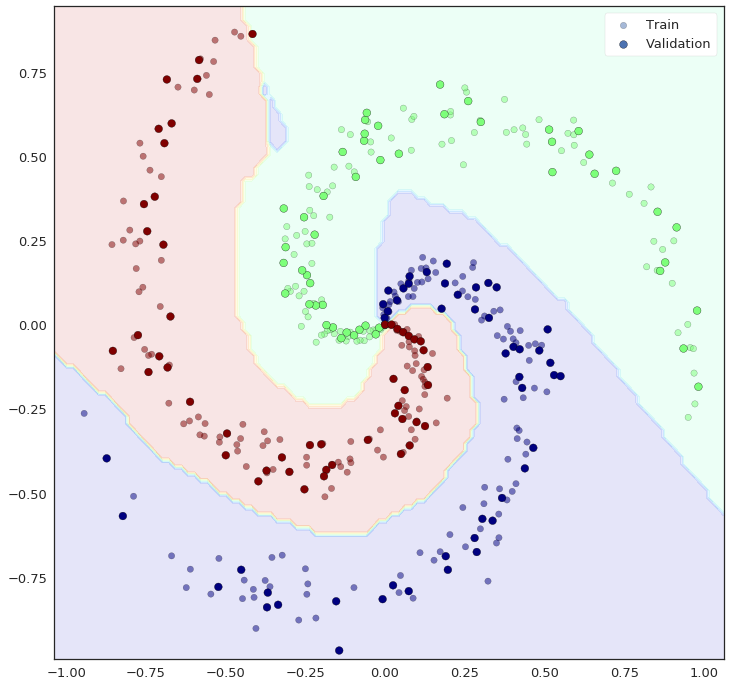

In [29]:
plot_model(model_mlp_multi, X_train, y_train, (X_valid, y_valid))

In [30]:
print("Train accuracy: {:.1f}%".format(model_mlp_multi.score(X_train, y_train)["acc"] * 100))
print("Valid accuracy: {:.1f}%".format(model_mlp_multi.score(X_valid, y_valid)["acc"] * 100))

Train accuracy: 99.3%
Valid accuracy: 98.0%


The quality seems to be almost the same as with the shallow NN but the decision surface is much more unstable which leads to the worse generalization ability.

This might happened due to the bad hyperparameter setting ot inappropriate learning method.

# Assignment

## Task 1

** Regression **

* Implement a regression objective function (mean squared error) for a single hidden layer neural network (section 5). 

    **HINT 1**: please use `MLPHomegrownSoftmax` as a base class and inherit from it to create `MLPHomegrownMSE` class
    
    **HINT 2**: you should override 4 methods: 
    * _grad
    * _predict_raw
    * score
    * predict
  

* Perform a regression task with Boston House Prices dataset using the `MLPHomegrownMSE` framework with 10 hidden nodes for regression. You can load Boston dataset with sklearn as we did before (see the course Labs notebook `Unit04_MLP_BostonHousePrices` for an example of this).
* Compare the results you obtain with the Sklearn Linear Regression model. You MLP approach should provide big improvement.
* Explore different architectures for this problem and report best NN architecture for your single hidden layer MLP.

Load Boston house prices dataset

In [31]:
boston = load_boston()

Create pandas dataframe with objects in rows and features in columns

In [32]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

Let's split our data to train and test set in fraction of $\frac{4}{1}$

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's also do normalization to the range of $(0; 1)$ to make our data insensitive to the scale of features

In [34]:
scaler = MinMaxScaler()

Note that we're going to learn normalization constants only on training set. That's done because the assumption is that test set is unreachable during training.

In [35]:
X_train = scaler.fit_transform(X_train)

Transform test set with the same constants

In [36]:
X_test = scaler.transform(X_test)

Here we use Scikit-learn Linear Regression model as a baseline.

In [37]:
model_sk = LinearRegression()

Fitting model on prepared data

In [38]:
model_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

There is no MAPE implementation in sklearn (because this metric is undefined when real value is zero). Below one can find my own implementation

In [39]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel())) * 100

Let's evaluate our model according to three different metrics:
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

In [40]:
metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           mean_absolute_percentage_error]
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]

Also we want to check quality on both train and test sets

In [41]:
samples = [(X_train, y_train), 
           (X_test, y_test)]

Let's do it in loop

In [42]:
def evaluate(models, metrics, samples, metrics_names, models_names):
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        samples_names.extend([m + " Train", m + " Test"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                results[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    return results

In [43]:
models = [model_sk]
models_names = ["Sklearn"]

Evaluated metrics:

In [44]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585


In [45]:
class MLPHomegrownMSE(MLPHomegrownSoftmax):
    
    def __init__(self, layer_config=[], random_state=21, verbose=True, _allow_multiple_layers=False):
        """
        Constructor for the homegrown MLP
        """
        # call the constructor of the parent class
        super(MLPHomegrownMSE, self).__init__(layer_config=layer_config, 
                                              random_state=random_state, 
                                              verbose=verbose, 
                                              _allow_multiple_layers=_allow_multiple_layers)
    
    def _predict_raw(self, X, store=True):
        """
        Computes scores for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each object
        """

        # evaluate class scores
        hidden_layer = np.maximum(0, np.dot(X, self._Ws[0]) + self._bs[0]) # ReLU activation
        
        # keep for later calulation 
        if store:
            self.hidden_layer = hidden_layer

        # raw scores
        scores = np.dot(hidden_layer, self._Ws[1]) + self._bs[1]

        return scores
    
    def predict(self, X):
        """
        Do a prediction for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            preds(ndarray):  prediction for each object
        """
        
        # get scores for each class
        preds = self._predict_raw(X)

        # in case of regression scores are predictions
        return preds
    
    def score(self, X, y, store=True):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            store(bool):     persist the results in the object
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy (rmse) 
                             and for objective function
        """
        
        # get predictions
        preds = self._predict_raw(X, store=store)
        
        # calculate errors
        errors = preds - y
        
        # MSE loss
        data_loss = np.mean(errors ** 2)
        
        # use RMSE as an "accuracy"
        rmse = np.sqrt(data_loss)
        
        # final metrics
        metrics = {"acc": rmse, "loss": data_loss}
        
        # persist the results in the object
        if store:
            self.preds = preds
            self.loss = data_loss
        
        return metrics
    
    def _grad(self, X, y):
        """
        Calculates the gradient.
        Only works for one hidden layer for now.

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
                  
        hidden_layer = self.hidden_layer    
        W2 = self._Ws[1]
        
        # calculate errors using preidctions from the current step
        # score function is called in fit and updates self.preds
        errors = self.preds - y
        
        # compute the gradient on scores
        dscores = 2.0 * errors / X.shape[0]

        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        #db2 = np.sum(dscores, axis=0, keepdims=True)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # finally into W,b
        dW1 = np.dot(X.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        
        # Store the updates # FIXME for multiple hidden
        self._dWs = [dW1, dW2]
        self._dbs = [db1, db2]

Construct model

In [46]:
model_1l = MLPHomegrownMSE(layer_config=[13, 10, 1], random_state=21)

Fit it

In [47]:
model_1l.fit(X_train, y_train[:, None], 
             max_iter=40000, alpha=0.006, 
             val_data=(X_test, y_test[:, None]))

iteration 1000: loss 16.689654
iteration 2000: loss 14.104167
iteration 3000: loss 11.455847
iteration 4000: loss 8.922509
iteration 5000: loss 7.990411
iteration 6000: loss 7.466393
iteration 7000: loss 7.175811
iteration 8000: loss 6.852528
iteration 9000: loss 6.719909
iteration 10000: loss 6.651621
iteration 11000: loss 6.626542
iteration 12000: loss 6.537909
iteration 13000: loss 6.497515
iteration 14000: loss 6.455108
iteration 15000: loss 6.359022
iteration 16000: loss 6.345079
iteration 17000: loss 6.312774
iteration 18000: loss 6.311559
iteration 19000: loss 6.265551
iteration 20000: loss 6.322206
iteration 21000: loss 6.272882
iteration 22000: loss 6.297680
iteration 23000: loss 6.180102
iteration 24000: loss 6.217002
iteration 25000: loss 6.230892
iteration 26000: loss 6.142131
iteration 27000: loss 6.129537
iteration 28000: loss 6.110894
iteration 29000: loss 6.145834
iteration 30000: loss 6.069420
iteration 31000: loss 6.049595
iteration 32000: loss 6.065929
iteration 3300

Visualize training

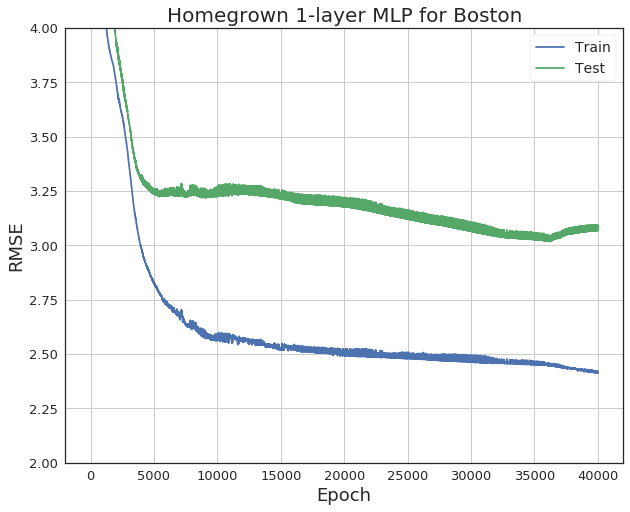

In [48]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(model_1l.history["acc"]), label="Train")
plt.plot(np.array(model_1l.history["val_acc"]), label="Test")
plt.grid("on")
plt.legend(framealpha=1.0, fontsize=14)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.title("Homegrown 1-layer MLP for Boston", fontsize=20)
plt.ylim([2, 4]);

In [49]:
models = [model_sk, model_1l]
models_names = ["Sklearn", "1L 10 MLP"]

Evaluated metrics:

In [50]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
1L 10 MLP Train,1.793841,2.415845,9.162843
1L 10 MLP Test,2.027295,3.069804,10.704649


We get almost 40% better RMSE in comparison with scikit learn Linear Regression model!

Let's try to experiment a bit with the architectures. For that purpose let's iterate over the grid of number of units in the hidden layer and see what works best

In [51]:
n_hidden_units = np.concatenate([np.arange(1, 20, 2), np.arange(20, 50, 5), np.arange(50, 100, 10)])
print("Grid:", n_hidden_units)

Grid: [ 1  3  5  7  9 11 13 15 17 19 20 25 30 35 40 45 50 60 70 80 90]


In [52]:
# arrays to store results of the experiments
rmses_train = np.zeros_like(n_hidden_units, dtype=np.float32)
rmses_test = np.zeros_like(n_hidden_units, dtype=np.float32)
# progress bar
bar = ProgressBar(max_value=len(n_hidden_units))
# iterate over grid
for i in bar(range(len(n_hidden_units))):
    # create model
    _model_1l = MLPHomegrownMSE(layer_config=[13, n_hidden_units[i], 1], random_state=21, verbose=False)
    # fit model
    _model_1l.fit(X_train, y_train[:, None], 
                  max_iter=40000, alpha=0.006)
    # evaluate model
    rmses_train[i] = np.sqrt(mean_squared_error(y_train, _model_1l.predict(X_train)))
    rmses_test[i] = np.sqrt(mean_squared_error(y_test, _model_1l.predict(X_test)))

100% (21 of 21) |#########################| Elapsed Time: 0:03:36 Time: 0:03:36


Let's visualize the results of our experiments

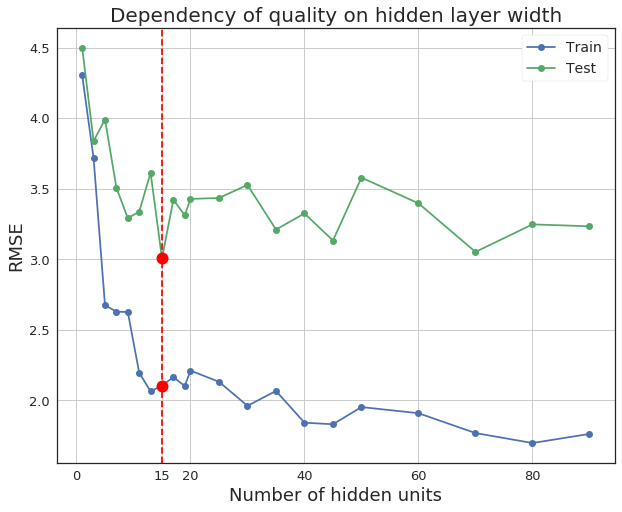

In [53]:
plt.figure(figsize=(10, 8))
# rmses of experiments
plt.plot(n_hidden_units, rmses_train, "-o", label="Train")
plt.plot(n_hidden_units, rmses_test, "-o", label="Test")
# optimal value
plt.plot(n_hidden_units[np.argmin(rmses_test)], rmses_test[np.argmin(rmses_test)], "ro", markersize=12)
plt.plot(n_hidden_units[np.argmin(rmses_test)], rmses_train[np.argmin(rmses_test)], "ro", markersize=12)
plt.axvline(n_hidden_units[np.argmin(rmses_test)], color="r", linestyle="--")
# styling
plt.xlabel("Number of hidden units", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.title("Dependency of quality on hidden layer width", fontsize=20)
xlims = plt.xlim()
plt.xticks(plt.xticks()[0].tolist() + [n_hidden_units[np.argmin(rmses_test)]])
plt.xlim(xlims)
plt.grid("on")
plt.legend(framealpha=1.0, fontsize=14);

From the graph above one can notice that after some threshold hidden layer width (approximately 10) the overfitting starts to become more and more significant. After that threshold the test quality stops improving while the train quality almost constantly improves. It's also worth to mention that we used the same optimizer hyperparameters for all the networks while for some of them this set of hyperparameters might not be optimal.

## Task 2

** Regression **

* Implement a regression objective function (mean squared error) for a multilayer layer neural network (section 5).

    **HINT 1**: please use `MLPHomegrownSoftmaxMulti` as a base class and inherit from it to create `MLPHomegrownMSEMulti` class
    
    **HINT 2**: you should override 4 methods: 
    * _grad
    * _predict_raw
    * score
    * predict
  

* Perform a regression task with Boston House Prices dataset using the `MLPHomegrownMSE` framework with 2 hidden layers and [100, 30] hidden nodes configuration for regression.
* Compare the results you obtain with the Sklearn Linear Regression model and single layer model from the previous task.
* Explore different architectures for this problem and report best NN architecture for your multilayer hidden layer MLP.

In [54]:
class MLPHomegrownMSEMulti(MLPHomegrownMSE):
    
    def __init__(self, layer_config=[], random_state=21, verbose=True, _allow_multiple_layers=True):
        """
        Constructor for the homegrown MLP
        """
        # call the constructor of the parent class
        super(MLPHomegrownMSEMulti, self).__init__(layer_config=layer_config, 
                                                   random_state=random_state, 
                                                   verbose=verbose, 
                                                   _allow_multiple_layers=_allow_multiple_layers)
    
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        
        # calculate errors using preidctions from the current step
        # score function is called in fit and updates self.preds
        errors = self.preds - y
        
        # compute the gradient on scores
        dscores = 2.0 * errors / X.shape[0]
        
        delta = dscores
        dWs = [np.zeros_like(W) for W in self._Ws]
        dbs = [np.zeros_like(b) for b in self._bs]
        Ws = self._Ws
        Os = self._Os
        
        for neg_id in range(self.n_hidden + 1):
            j = -1 - neg_id
            Wj = Ws[j] # output
            hj = Os[j] # hidden
            # backpropate the gradient to the parameters
            # first backprop into parameters W2 and b2
            dW = np.dot(hj.T, delta) # gradient
            db = np.sum(delta, axis=0, keepdims=True)
            # next backprop into hidden layer
            dhidden = np.dot(delta, Wj.T)
            # backprop the ReLU non-linearity
            dhidden[hj <= 0] = 0
            
            # update delta
            delta = dhidden
            
            # store updates
            dWs[j] = dW
            dbs[j] = db

        # Store the updates 
        self._dWs = dWs
        self._dbs = dbs

    def _predict_raw(self, X, store=True):
        """
        Forward prop
        
        Computes scores for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """
        # output for the input layer is its actual input value
        Os = [X]

        # propagate the inputs forward 
        for j in range(self.n_hidden):
            # evaluate class scores
            hidden_layer = np.maximum(0, np.dot(Os[j], self._Ws[j]) + self._bs[j]) # ReLU activation
            Os.append(hidden_layer)

        # keep for later calulation 
        if store:
            self._Os = Os

        scores = np.dot(Os[-1], self._Ws[-1]) + self._bs[-1]
        
        return scores

Create model

In [55]:
model_2l = MLPHomegrownMSEMulti(layer_config=[13, 100, 30, 1])

Train model

In [56]:
model_2l.fit(X_train, y_train[:, None], 
             max_iter=25000, alpha=1e-3, 
             val_data=(X_test, y_test[:, None]))

iteration 1000: loss 15.771224
iteration 2000: loss 14.011791
iteration 3000: loss 13.014176
iteration 4000: loss 11.201267
iteration 5000: loss 9.384738
iteration 6000: loss 7.931971
iteration 7000: loss 6.930714
iteration 8000: loss 6.370885
iteration 9000: loss 5.924890
iteration 10000: loss 5.725816
iteration 11000: loss 5.481634
iteration 12000: loss 5.212519
iteration 13000: loss 4.788390
iteration 14000: loss 4.641372
iteration 15000: loss 4.489400
iteration 16000: loss 4.492597
iteration 17000: loss 4.395907
iteration 18000: loss 4.344767
iteration 19000: loss 4.129718
iteration 20000: loss 4.112279
iteration 21000: loss 3.969266
iteration 22000: loss 3.892181
iteration 23000: loss 3.732513
iteration 24000: loss 3.590350
iteration 25000: loss 3.566536


Visualize training

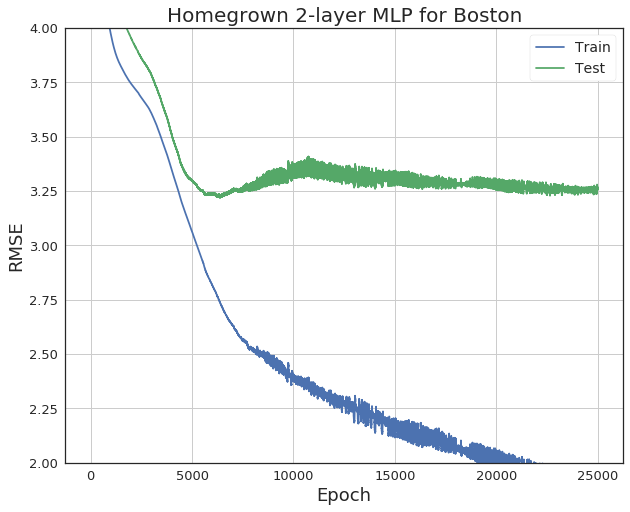

In [57]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(model_2l.history["acc"]), label="Train")
plt.plot(np.array(model_2l.history["val_acc"]), label="Test")
plt.grid("on")
plt.legend(framealpha=1.0, fontsize=14)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.title("Homegrown 2-layer MLP for Boston", fontsize=20)
plt.ylim([2, 4]);

In [58]:
models = [model_sk, model_1l, model_2l]
models_names = ["Sklearn", "1L 10 MLP", "2L 100-30 MLP"]

Evaluated metrics:

In [59]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
1L 10 MLP Train,1.793841,2.415845,9.162843
1L 10 MLP Test,2.027295,3.069804,10.704649
2L 100-30 MLP Train,1.373118,1.899562,6.841953
2L 100-30 MLP Test,2.000290,3.262365,9.964395


As one can notice this 2-layer configuration worked worse than 1-layer. Let's try to investigate the architectures further.

In [60]:
model_2l_ext = MLPHomegrownMSEMulti(layer_config=[13, 13, 10 , 1], random_state=21, verbose=False)
model_2l_ext.fit(X_train, y_train[:, None], max_iter=40000, alpha=0.006)

Compare models

In [61]:
models = [model_sk, model_1l, model_2l, model_2l_ext]
models_names = ["Sklearn", "1L 10 MLP", "2L 100-30 MLP", "2l 13-10 MLP"]

Evaluated metrics:

In [62]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
1L 10 MLP Train,1.793841,2.415845,9.162843
1L 10 MLP Test,2.027295,3.069804,10.704649
2L 100-30 MLP Train,1.373118,1.899562,6.841953
2L 100-30 MLP Test,2.000290,3.262365,9.964395
2l 13-10 MLP Train,1.313050,1.779031,6.920646
2l 13-10 MLP Test,2.162758,2.903186,11.700604


This one works much better! It might mean that the previous architecture was too complicated. One can also notice that with the deep architectures the ovefitting problem starts playing more and more crucial role. We can try to avoid it using regularization

# Optional assignments

## Task 3

* Implement a **L2-regularized MSE** objective function for regression multilayer neural network. Inherit from `MLPHomegrownMSEMulti` class.
* Test it against previous methods on Boston dataset

In [63]:
class MLPHomegrownMSEMultiReg(MLPHomegrownMSEMulti):
    
    def __init__(self, layer_config=[], random_state=21, verbose=True, _allow_multiple_layers=True, 
                 l1_reg=0.0, l2_reg=0.0):
        """
        Constructor for the homegrown MLP
        """
        # call the constructor of the parent class
        super(MLPHomegrownMSEMultiReg, self).__init__(layer_config=layer_config, 
                                                      random_state=random_state, 
                                                      verbose=verbose, 
                                                      _allow_multiple_layers=_allow_multiple_layers)
        # regularization constants
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
    
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        
        # calculate errors using preidctions from the current step
        # score function is called in fit and updates self.preds
        errors = self.preds - y
        
        # compute the gradient on scores
        dscores = 2.0 * errors / X.shape[0]
        
        delta = dscores
        dWs = [np.zeros_like(W) for W in self._Ws]
        dbs = [np.zeros_like(b) for b in self._bs]
        Ws = self._Ws
        Os = self._Os
        
        for neg_id in range(self.n_hidden + 1):
            j = -1 - neg_id
            Wj = Ws[j] # output
            hj = Os[j] # hidden
            # backpropate the gradient to the parameters
            # first backprop into parameters W2 and b2
            dW = np.dot(hj.T, delta) # gradient
            dW += self.l1_reg * np.sign(Wj) + 2 * self.l2_reg * Wj
            db = np.sum(delta, axis=0, keepdims=True)
            # next backprop into hidden layer
            dhidden = np.dot(delta, Wj.T)
            # backprop the ReLU non-linearity
            dhidden[hj <= 0] = 0
            
            # update delta
            delta = dhidden
            
            # store updates
            dWs[j] = dW
            dbs[j] = db

        # Store the updates 
        self._dWs = dWs
        self._dbs = dbs

Let's try the "deep" 100-30 architecture with L2 regularization which was prone to overfitting the most.

In [64]:
model_2l_regl2 = MLPHomegrownMSEMultiReg(layer_config=[13, 100, 30 , 1], random_state=21, verbose=False, 
                                         l2_reg=0.05)
model_2l_regl2.fit(X_train, y_train[:, None], max_iter=40000, alpha=0.005)

Compare models

In [65]:
models = [model_sk, model_1l, model_2l, model_2l_ext, model_2l_regl2]
models_names = ["Sklearn", "1L 10 MLP", "2L 100-30 MLP", "2l 13-10 MLP", "2l 100-30 MLP L2"]

Evaluated metrics:

In [66]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
1L 10 MLP Train,1.793841,2.415845,9.162843
1L 10 MLP Test,2.027295,3.069804,10.704649
2L 100-30 MLP Train,1.373118,1.899562,6.841953
2L 100-30 MLP Test,2.000290,3.262365,9.964395
2l 13-10 MLP Train,1.313050,1.779031,6.920646
2l 13-10 MLP Test,2.162758,2.903186,11.700604
2l 100-30 MLP L2 Train,2.028978,2.660870,10.879228
2l 100-30 MLP L2 Test,2.408036,3.490100,13.433967


As a result we can see that the difference between train and test quality indeed becomes smaller

## Task 4

* Implement a **L2-regularized crossentropy** objective function for classification multilayer neural network. Inherit from `MLPHomegrownSoftmaxMulti` class.
* Test it against previous methods on Spirals dataset

In [67]:
class MLPHomegrownSoftmaxMultiReg(MLPHomegrownSoftmaxMulti):
    
    def __init__(self, layer_config=[], random_state=21, verbose=True, _allow_multiple_layers=True, 
                 l1_reg=0.0, l2_reg=0.0):
        """
        Constructor for the homegrown MLP
        """
        # call the constructor of the parent class
        super(MLPHomegrownSoftmaxMultiReg, self).__init__(layer_config=layer_config, 
                                                          random_state=random_state, 
                                                          verbose=verbose, 
                                                          _allow_multiple_layers=_allow_multiple_layers)
        
        # regularization constants
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg

    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        # number of training examples
        num_examples = X.shape[0]
        
        # get probs from last scoring step
        probs = self.probs

        # compute the gradient on scores
        # Calculate the error; subtract 1 since we only have on class
        # that is 'on' at a time (even though we have multiple classes)
        dscores = probs
        dscores[range(num_examples), y] -= 1
        # normalize by dividing by number of examples
        dscores /= num_examples
        
        delta = dscores
        dWs = [np.zeros_like(W) for W in self._Ws]
        dbs = [np.zeros_like(b) for b in self._bs]
        Ws = self._Ws
        Os = self._Os
        
        for neg_id in range(self.n_hidden + 1):
            j = -1 - neg_id
            Wj = Ws[j] # output
            hj = Os[j] # hidden
            # backpropate the gradient to the parameters
            # first backprop into parameters W2 and b2
            dW = np.dot(hj.T, delta) # gradient
            dW += self.l1_reg * np.sign(Wj) + 2 * self.l2_reg * Wj
            db = np.sum(delta, axis=0, keepdims=True)
            # next backprop into hidden layer
            dhidden = np.dot(delta, Wj.T)
            # backprop the ReLU non-linearity
            dhidden[hj <= 0] = 0
            
            # update delta
            delta = dhidden
            
            # store updates
            dWs[j] = dW
            dbs[j] = db

        # Store the updates 
        self._dWs = dWs
        self._dbs = dbs

Create model with the same configuration as before (for Spirals) and train it using L2 regularization

In [68]:
model_mlp_multi_regl2 = MLPHomegrownSoftmaxMultiReg(layer_config=[2, 40, 40, 40, 3], 
                                                    random_state=21, verbose=True, 
                                                    l2_reg=0.00005)
model_mlp_multi_regl2.fit(*get_data(random_state=21), max_iter=10000, alpha=5e-1)

iteration 1000: loss 1.098612
iteration 2000: loss 1.098612
iteration 3000: loss 1.098611
iteration 4000: loss 1.098610
iteration 5000: loss 1.098601
iteration 6000: loss 0.948345
iteration 7000: loss 0.040135
iteration 8000: loss 0.027025
iteration 9000: loss 0.032882
iteration 10000: loss 0.019424


Let's compare norms of weight matrices

In [69]:
print("{:17s}{:10s}{:10s}".format("", "No", "L2"))
for i in range(len(model_mlp_multi._Ws)):
    print("{:17s}{:.1f}      {:.1f}".format(
                        "W" + str(i + 1) + " 2-norm ^ 2", 
                        np.linalg.norm(model_mlp_multi._Ws[i], 2) ** 2, 
                        np.linalg.norm(model_mlp_multi_regl2._Ws[i], 2) ** 2))

                 No        L2        
W1 2-norm ^ 2    89.7      63.4
W2 2-norm ^ 2    29.1      26.6
W3 2-norm ^ 2    21.7      19.1
W4 2-norm ^ 2    28.9      26.4


One can notice that all the weight matrices have smaller L2 norm and thus hopefully less prone to the overfitting.

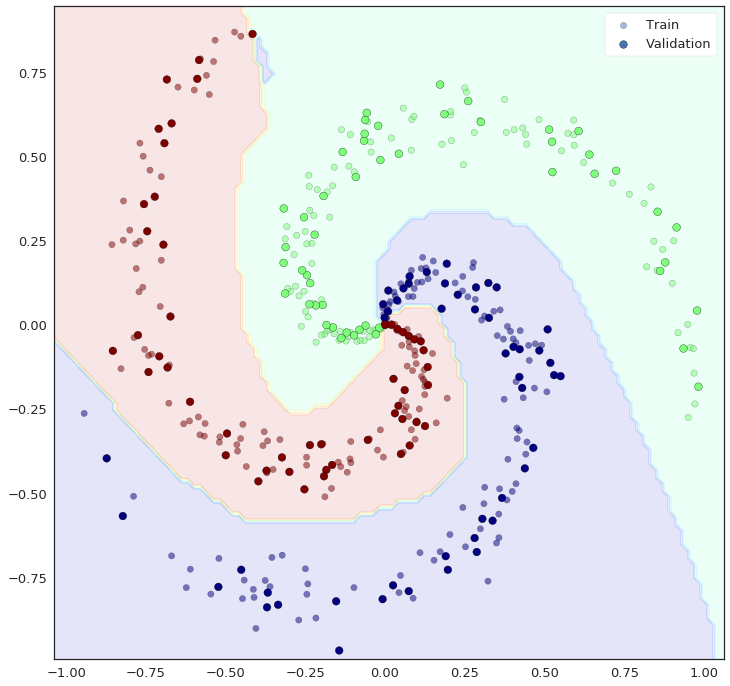

In [70]:
plot_model(model_mlp_multi_regl2, *get_data(random_state=21), get_data(n_samples=50, random_state=12))

And accuracies

In [71]:
print("Train accuracy: {:.1f}%".format(model_mlp_multi_regl2.score(*get_data(random_state=21))["acc"] * 100))
print("Valid accuracy: {:.1f}%".format(model_mlp_multi_regl2.score(*get_data(n_samples=50, 
                                                                             random_state=12))["acc"] * 100))

Train accuracy: 99.3%
Valid accuracy: 98.0%


## Task 5

* Implement a **L1-regularized MSE** objective function for regression multilayer neural network. Inherit from `MLPHomegrownMSEMulti` class.
* Test it against previous methods on Boston dataset

Let's try the previous Boston architecture with L1 regularization

In [72]:
model_2l_regl1 = MLPHomegrownMSEMultiReg(layer_config=[13, 100, 30 , 1], random_state=21, verbose=False, 
                                         l1_reg=0.01)
model_2l_regl1.fit(X_train, y_train[:, None], max_iter=40000, alpha=0.005)

Compare models

In [73]:
models = [model_sk, model_1l, model_2l, model_2l_ext, model_2l_regl2, model_2l_regl1]
models_names = ["Sklearn", "1L 10 MLP", "2L 100-30 MLP", "2l 13-10 MLP", "2l 100-30 MLP L2", "2l 100-30 MLP L1"]

Evaluated metrics:

In [74]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
1L 10 MLP Train,1.793841,2.415845,9.162843
1L 10 MLP Test,2.027295,3.069804,10.704649
2L 100-30 MLP Train,1.373118,1.899562,6.841953
2L 100-30 MLP Test,2.000290,3.262365,9.964395
2l 13-10 MLP Train,1.313050,1.779031,6.920646
2l 13-10 MLP Test,2.162758,2.903186,11.700604
2l 100-30 MLP L2 Train,2.028978,2.660870,10.879228
2l 100-30 MLP L2 Test,2.408036,3.490100,13.433967


## Task 6

* Implement a **L1-regularized crossentropy** objective function for classification multilayer neural network. Inherit from `MLPHomegrownSoftmaxMulti` class.
* Test it against previous methods on Spirals dataset

Create model with the 1-layer configuration as before (for Spirals) and train it using L1 regularization

In [75]:
model_mlp_regl1 = MLPHomegrownSoftmaxMultiReg(layer_config=[2, 100, 3], 
                                                    random_state=21, verbose=True, 
                                                    l1_reg=0.0001)
model_mlp_regl1.fit(*get_data(random_state=21), max_iter=20000, alpha=5e-1)

iteration 1000: loss 0.331037
iteration 2000: loss 0.135087
iteration 3000: loss 0.085841
iteration 4000: loss 0.064609
iteration 5000: loss 0.053625
iteration 6000: loss 0.046487
iteration 7000: loss 0.041360
iteration 8000: loss 0.037663
iteration 9000: loss 0.034964
iteration 10000: loss 0.032912
iteration 11000: loss 0.031322
iteration 12000: loss 0.030070
iteration 13000: loss 0.029043
iteration 14000: loss 0.028198
iteration 15000: loss 0.027473
iteration 16000: loss 0.026845
iteration 17000: loss 0.026295
iteration 18000: loss 0.025814
iteration 19000: loss 0.025385
iteration 20000: loss 0.024999


1-norm of the weight matrices

In [76]:
print("{:17s}{:10s}{:10s}".format("", "No", "L1"))
for i in range(len(model_mlp._Ws)):
    print("{:17s}{:.1f}      {:.1f}".format(
                        "W" + str(i + 1) + " 1-norm", 
                        np.linalg.norm(model_mlp._Ws[i], 1), 
                        np.linalg.norm(model_mlp_regl1._Ws[i], 1)))

                 No        L1        
W1 1-norm        11.8      13.8
W2 1-norm        91.8      55.2


Decision surface

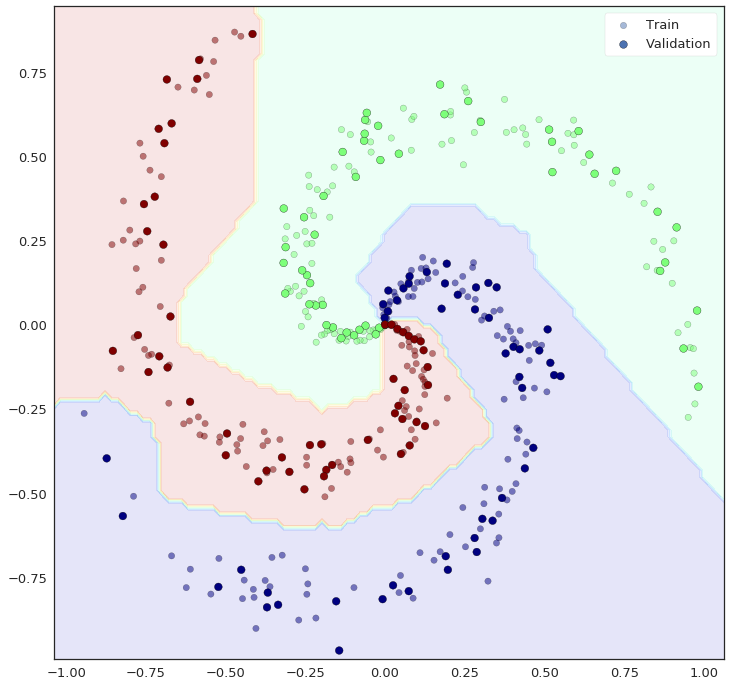

In [77]:
plot_model(model_mlp_regl1, *get_data(random_state=21), get_data(n_samples=50, random_state=12))

Metrics

In [78]:
print("Train accuracy: {:.1f}%".format(model_mlp_regl1.score(*get_data(random_state=21))["acc"] * 100))
print("Valid accuracy: {:.1f}%".format(model_mlp_regl1.score(*get_data(n_samples=50, 
                                                                       random_state=12))["acc"] * 100))

Train accuracy: 99.3%
Valid accuracy: 98.7%
